In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
!mkdir -p audio


Speech Command Classification with torchaudio
*********************************************

from [https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html](https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html)


This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
`torchaudio <https://github.com/pytorch/audio>`__ that can be installed
by following the instructions on the website.




In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
from src import *
from IPython.core.display import display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import pandas as pd

Importing the Dataset
---------------------

We use torchaudio to download and represent the dataset. Here we use
`SpeechCommands <https://arxiv.org/abs/1804.03209>`__, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [3]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")
val_set = SubsetSC("validation")
waveform, sample_rate, label, speaker_id, utterance_number = train_set[1]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


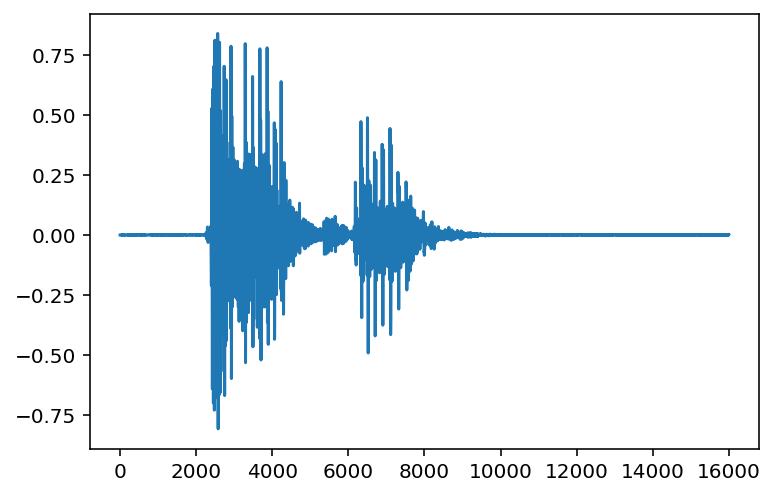

In [4]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [5]:
# inline audio playback for transfer
audio_counter = 1
class PlayAudio:
    def __init__(self):
        self.counter = 1
    def __call__(self, waveform, rate, p=True):
        fn = f'audio/{self.counter}.mp3'
        self.counter += 1
        torchaudio.save(fn, waveform, rate)
        if p:
            print(fn)
        return ipd.Audio(filename=fn)
playaudio = PlayAudio()

In [6]:
playaudio(waveform, sample_rate)

audio/1.mp3


Let’s find the list of labels available in the dataset.




In [7]:
labels = ['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

Formatting the Data
-------------------

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [8]:
new_sample_rate = 16000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

playaudio(transformed, rate=new_sample_rate)

audio/2.mp3


We are encoding each word using its index in the list of labels.




In [9]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see `the
documentation <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`__
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [10]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 128

num_workers = 4
pin_memory = True


train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Training and Testing the Network
--------------------------------


In [11]:
def f(model, attack, n=1, check_correct=True):
    w = 0
    for data in test_loader:
        x, y = map(lambda x: x.cuda(), data)
        model.train(False)
        adv = attack(model, x, y)
        pa = model(adv)
        p = model(x)
        for ind in range(x.size(0)):
            if check_correct and p[ind, :].argmax() != y[ind]:
                continue
            if w >= n:
                break
                
            w += 1
            fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)
            
            fig.patch.set_facecolor('white')
            fig.suptitle(f'{labels[y[ind].item()]}: {labels[model(x).argmax(axis=1)[ind].item()]} → {labels[model(adv).argmax(axis=1)[ind].item()]}')
            
            ax1.plot(x[ind, :, 0].cpu().t().numpy())
            ax1.set_title("original")
            
            ax2.plot(adv[ind, :, 0].cpu().t().numpy())
            ax2.set_title("adversarial")
            
            ax3.plot((adv-x)[ind, :, 0].cpu().t().numpy())
            ax3.set_title("noise")
            print(adv[ind, :, :].shape)
            
            display(playaudio(x[ind, :, :].cpu().t(), rate=new_sample_rate))
            display(playaudio(adv[ind, :, :].cpu().t(), rate=new_sample_rate))
            fig.show()
        if w >= n:
            break
    if check_correct and w < n:
        f(model, attack, n - w, False)

In [12]:

            
class Block(nn.Module):
    def __init__(self, n_input, n_output, kernel_size, stride, p):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(n_input)
        self.bn2 = nn.BatchNorm1d(n_output)
        
        self.dropout = nn.Dropout(p)
        
        self.conv1 = nn.Conv1d(n_input, n_output, kernel_size=kernel_size, padding=(kernel_size // 2), stride=stride)
        self.conv2 = nn.Conv1d(n_output, n_output, kernel_size=kernel_size, padding='same', stride=1)
        
        self.conv_res = nn.Conv1d(n_input, n_output, kernel_size=1, padding=2 if stride > 1 else 0, stride=stride)
    def forward(self, x):
        x_out = F.relu(self.bn1(x))
        # print(x_out.shape)
        out = (self.dropout(F.relu(self.bn2(self.conv1(x_out)))))
        # print(out.shape)
        out = self.conv2(out)
        # print(out.shape)
        x_out = self.conv_res(x_out)
        # print(x_out.shape)
        return torch.add(x_out, out)
        
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32, p=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        # self.conv1 = Block(n_input, n_channel, kernel_size=80, stride=stride, p=p)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = Block(n_channel, n_channel, kernel_size=3, stride=1, p=p)
        self.pool2 = nn.MaxPool1d(4)
        
        self.conv3 = Block(n_channel, 2 * n_channel, kernel_size=3, stride=1, p=p)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)
        self.dropout = nn.Dropout(p=p)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x.squeeze()

torch.cuda.empty_cache()
from collections import OrderedDict
def mk_model(ϵ, K = 1, lr=0.1, weight_decay=1e-5, p=0.3, ϵ_s = None):
    ϵ_s = ϵ if ϵ_s is None else ϵ_s
    model = M5(p=p)
    if ϵ not in [0, False]:
        adv = AdversarialForFree(ϵ, -1, 1, e_s=ϵ_s)
        l = [('adv', adv)]
    else:
        l = []
    l.extend([('model', model)])
    model = nn.Sequential(OrderedDict(l)).cuda()
    optimizer = optim.SGD(model.parameters(), lr=lr, 
                          weight_decay=weight_decay, momentum=0.9, nesterov=True)
    scheduler = optim.lr_scheduler.StepLR(optimizer, math.ceil(5 / K), gamma=0.2)
    
    return model, optimizer, scheduler
# The transform needs to live on the same device as the model and the data.

transform = transform.cuda()
model = mk_model(2)[0].cuda()
for x, y in train_loader:
    print(x.shape)
    print(model(x.cuda()).shape)
    break

torch.Size([128, 16000, 1])
torch.Size([128, 35])


In [13]:
# TODO CHANGE
EPOCH = 20
Nat_train_Ks =  [1, 2, 4, 10]
PGD_train_Ks = [1, 2, 4, 7]
Free_train_Ks = [1, 2, 4, 8, 10]

K = 100


ϵ = 0.01

ϵ_s = 2.5 * ϵ / K

ϵ_s_small = 0.5 * ϵ / K

attack = PGD(K, ϵ, ϵ_s, min=-1, max=1, early_stopping=True)
attacks = [attack]
name = f'{K}-PGD'
names = [name]


In [14]:
logs = defaultdict(lambda : defaultdict(lambda : defaultdict(lambda : [])))

In [15]:

for nat_K in Nat_train_Ks:
    model, optimizer, scheduler = mk_model(0, K=nat_K, lr=0.1)
    for epoch in range(math.ceil(EPOCH / nat_K)):
        logs['nat'][nat_K]['train'].append(train_with_replay(1, model, train_loader, optimizer, epoch))
        logs['nat'][nat_K]['val'].append(run_val(model, val_loader, epoch))
        logs['nat'][nat_K]['test'].append(run_val(model, test_loader, epoch, name='test'))
        scheduler.step()
        run_attacks(logs['nat'][nat_K], attacks, names, model, test_loader, epoch)
        run_attacks(logs['nat'][nat_K], attacks, names, model, val_loader, epoch, category='adv_val')
    normal_model = model



train 	 1: 1.7787 48.4% 5.6s
val 	 1: 0.8485 74.7% 0.8s
test 	 1: 0.8768 74.1% 1.0s
adv_test/100-PGD 	 1: 14.4343 0.0% 35.5s
adv_val/100-PGD 	 1: 14.8022 0.0% 33.6s
train 	 2: 0.9401 72.4% 5.7s
val 	 2: 0.5721 83.1% 0.8s
test 	 2: 0.5911 82.5% 0.8s
adv_test/100-PGD 	 2: 19.5824 0.0% 38.5s
adv_val/100-PGD 	 2: 18.3770 0.0% 31.0s
train 	 3: 0.7873 76.8% 7.5s
val 	 3: 0.5333 84.2% 0.9s
test 	 3: 0.5689 82.9% 1.0s
adv_test/100-PGD 	 3: 15.9444 0.0% 25.5s
adv_val/100-PGD 	 3: 16.0137 0.0% 23.8s
train 	 4: 0.7150 79.1% 6.7s
val 	 4: 0.5374 83.4% 1.0s
test 	 4: 0.5842 82.0% 1.0s
adv_test/100-PGD 	 4: 15.7406 0.0% 22.9s
adv_val/100-PGD 	 4: 15.7362 0.0% 21.3s
train 	 5: 0.6753 80.0% 7.4s
val 	 5: 0.4535 86.2% 0.9s
test 	 5: 0.4644 86.5% 0.9s
adv_test/100-PGD 	 5: 18.3288 0.0% 31.5s
adv_val/100-PGD 	 5: 19.2820 0.0% 32.7s
train 	 6: 0.5690 83.3% 7.5s
val 	 6: 0.3302 90.3% 0.9s
test 	 6: 0.3518 89.5% 1.0s
adv_test/100-PGD 	 6: 19.4236 0.0% 30.7s
adv_val/100-PGD 	 6: 20.0042 0.0% 29.5s
train 	 7:

torch.Size([16000, 1])
audio/3.mp3


audio/4.mp3


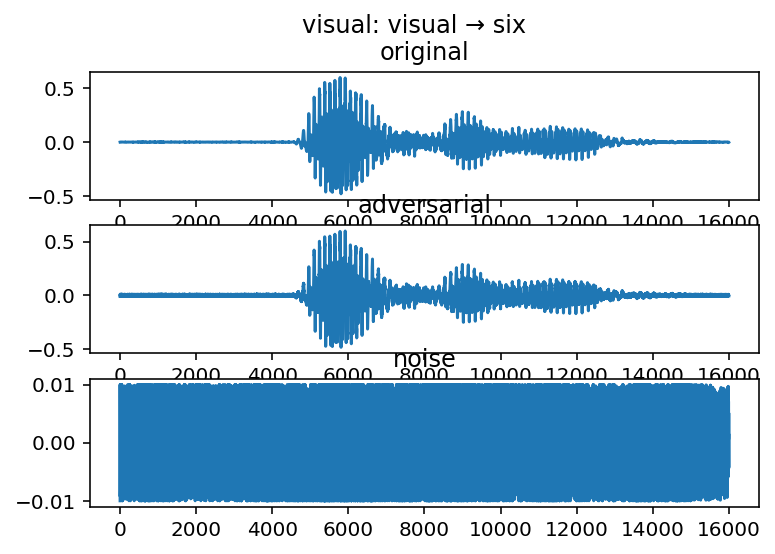

In [16]:
f(model, attack)

torch.Size([16000, 1])
audio/5.mp3


audio/6.mp3


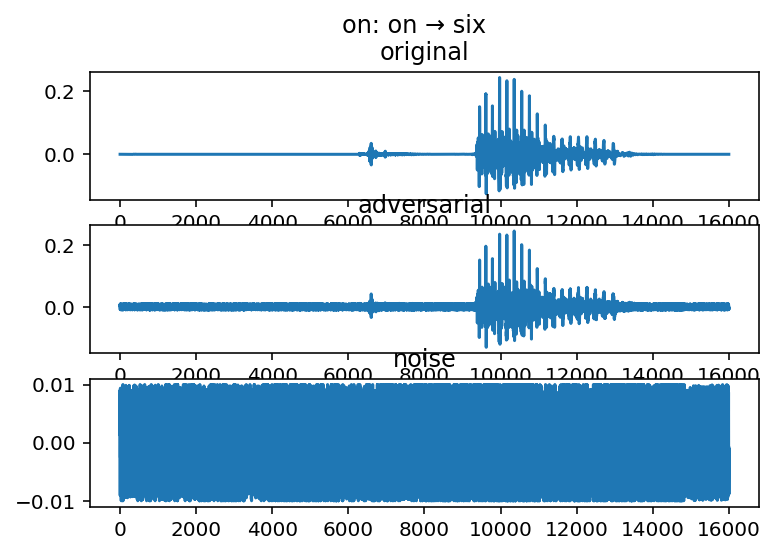

In [17]:
f(model, attack)

torch.Size([16000, 1])
audio/7.mp3


audio/8.mp3


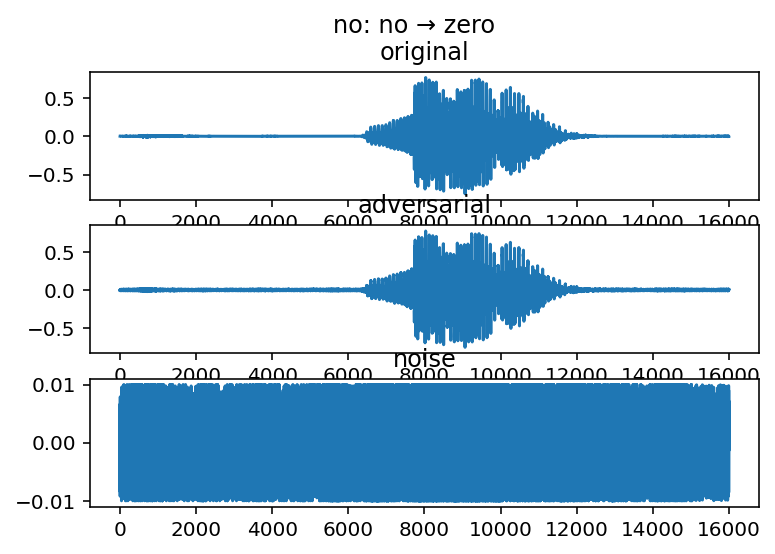

In [18]:
f(model, attack)

In [19]:
for PGD_train_K in PGD_train_Ks:
    for small_step in [True, False]:
        n = 'pgd' if not small_step else 'pgds'
 
        ϵ_s = 2.5 * ϵ / PGD_train_K
        if small_step:
            ϵ_s /= 5
        print(f'K: {PGD_train_K, ϵ_s}\n\n\n')
        train_attack = PGD(PGD_train_K, ϵ, e_s = ϵ_s, min=-1, max=1)
        model, optimizer, scheduler = mk_model(0, lr=0.1)
        for epoch in range(EPOCH):
            logs[n][PGD_train_K]['train'].append(train_with_replay(1, 
              model,
              train_loader,
              optimizer,
              epoch,
              input_func=lambda x, y: train_attack(model, x, y)))
            
            scheduler.step()
            
            logs[n][PGD_train_K]['val'].append(run_val(model, val_loader, epoch))
            logs[n][PGD_train_K]['test'].append(run_val(model, test_loader, epoch, name='test'))

            run_attacks(logs[n][PGD_train_K], attacks, names, model, test_loader, epoch)
            run_attacks(logs[n][PGD_train_K], attacks, names, model, val_loader, epoch, category='adv_val')


K: (1, 0.005)



train 	 1: 2.4255 29.9% 15.9s
val 	 1: 1.4546 59.6% 0.8s
test 	 1: 1.4588 59.5% 0.8s
adv_test/100-PGD 	 1: 2.9769 18.2% 125.2s
adv_val/100-PGD 	 1: 3.0019 18.0% 113.5s
train 	 2: 1.8706 44.2% 15.9s
val 	 2: 1.0873 70.4% 0.8s
test 	 2: 1.1112 69.9% 0.9s
adv_test/100-PGD 	 2: 3.0525 18.8% 125.7s
adv_val/100-PGD 	 2: 3.0477 18.0% 113.9s
train 	 3: 1.6676 50.1% 16.0s
val 	 3: 0.9370 74.4% 0.8s
test 	 3: 0.9488 73.7% 0.8s
adv_test/100-PGD 	 3: 3.1520 19.8% 127.1s
adv_val/100-PGD 	 3: 3.1489 19.2% 116.4s
train 	 4: 1.5251 54.1% 17.0s
val 	 4: 0.7922 78.1% 0.9s
test 	 4: 0.8138 77.2% 1.0s
adv_test/100-PGD 	 4: 3.1982 21.6% 128.9s
adv_val/100-PGD 	 4: 3.1827 19.9% 117.1s
train 	 5: 1.4558 56.1% 16.8s
val 	 5: 0.7670 79.1% 0.9s
test 	 5: 0.7750 78.8% 1.0s
adv_test/100-PGD 	 5: 2.9853 23.3% 126.6s
adv_val/100-PGD 	 5: 2.9711 22.1% 113.5s
train 	 6: 1.3287 59.9% 16.0s
val 	 6: 0.6793 81.4% 0.8s
test 	 6: 0.6910 81.2% 0.8s
adv_test/100-PGD 	 6: 3.1227 22.7% 128.5s
adv_val/100-PGD 

torch.Size([16000, 1])
audio/9.mp3


audio/10.mp3


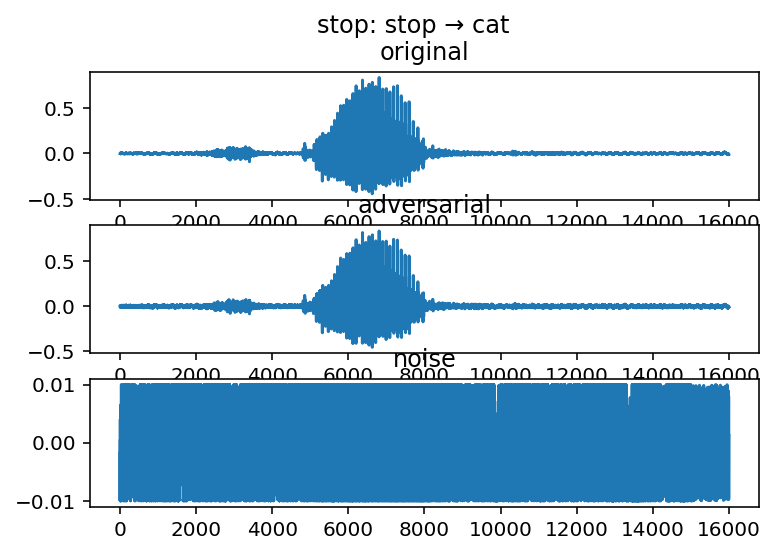

In [20]:
f(model, attack)

torch.Size([16000, 1])
audio/11.mp3


audio/12.mp3


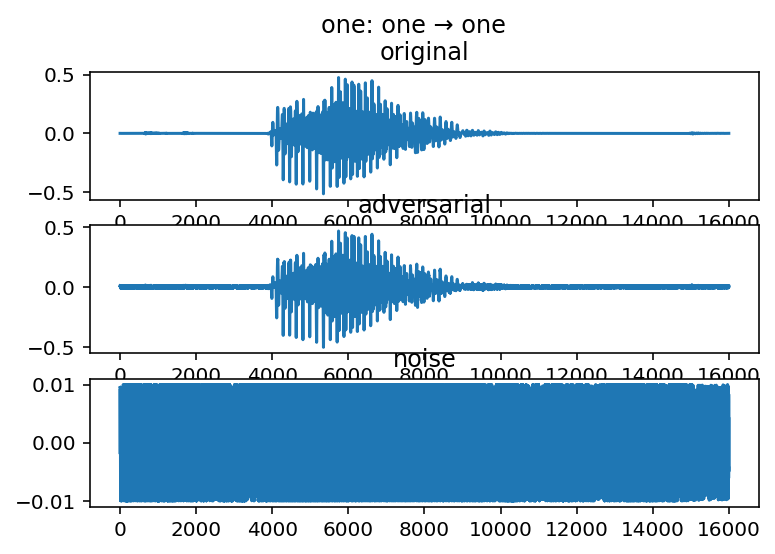

In [21]:
f(model, attack)

torch.Size([16000, 1])
audio/13.mp3


audio/14.mp3


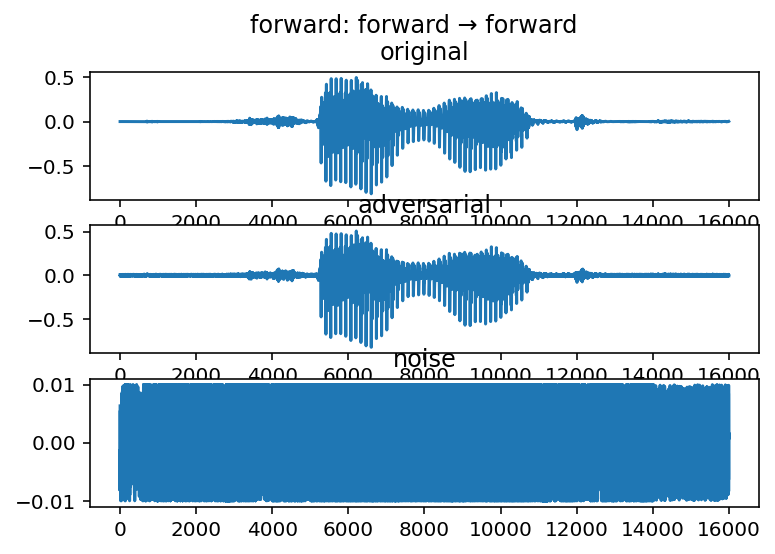

In [22]:
f(model, attack)

In [23]:

for small_step in [True, False]:
    for K in Free_train_Ks:
        print(f'K:{K, small_step}, \n\n\n\n')
        n = 'free' if not small_step else 'free-s'
        model, optimizer, scheduler = mk_model(ϵ, K=K, ϵ_s=ϵ if not small_step else ϵ / 2)
        for epoch in range(math.ceil(EPOCH / K)):
            l = train_with_replay(K, model, train_loader, optimizer, epoch, after_func=lambda model: model.adv.step())
            logs[n][K]['train'].append(l)
            logs[n][K]['test'].append(run_val(model, test_loader, epoch, name='test'))
            logs[n][K]['val'].append(run_val(model, val_loader, epoch))
            run_attacks(logs[n][K], attacks, names, model, test_loader, epoch)
            run_attacks(logs[n][K], attacks, names, model, val_loader, epoch, category='adv_val')
            scheduler.step()


K:(1, True), 




train 	 1: 1.8370 46.5% 15.2s
test 	 1: 1.1151 67.0% 1.0s
val 	 1: 1.0692 68.9% 0.9s
adv_test/100-PGD 	 1: 9.6061 0.1% 71.2s
adv_val/100-PGD 	 1: 9.4204 0.1% 62.2s
train 	 2: 1.0710 68.9% 15.1s
test 	 2: 0.8650 74.6% 0.9s
val 	 2: 0.8369 75.2% 0.8s
adv_test/100-PGD 	 2: 10.3294 0.4% 104.1s
adv_val/100-PGD 	 2: 10.1852 0.3% 92.7s
train 	 3: 0.9112 73.3% 14.5s
test 	 3: 0.6662 79.5% 0.9s
val 	 3: 0.6366 80.8% 0.8s
adv_test/100-PGD 	 3: 14.4019 0.1% 68.9s
adv_val/100-PGD 	 3: 13.8989 0.0% 59.8s
train 	 4: 0.8373 75.5% 15.7s
test 	 4: 0.5498 83.5% 1.0s
val 	 4: 0.4986 85.0% 1.0s
adv_test/100-PGD 	 4: 14.2832 0.0% 61.4s
adv_val/100-PGD 	 4: 13.6402 0.0% 51.3s
train 	 5: 0.7896 76.9% 15.6s
test 	 5: 0.5532 83.5% 1.0s
val 	 5: 0.5158 84.6% 0.8s
adv_test/100-PGD 	 5: 14.3638 0.2% 91.5s
adv_val/100-PGD 	 5: 13.6981 0.1% 77.6s
train 	 6: 0.6799 79.9% 15.6s
test 	 6: 0.4813 85.3% 1.0s
val 	 6: 0.4526 86.6% 1.0s
adv_test/100-PGD 	 6: 15.5036 0.1% 84.1s
adv_val/100-PGD 	 6: 14.876

torch.Size([16000, 1])
audio/15.mp3


audio/16.mp3


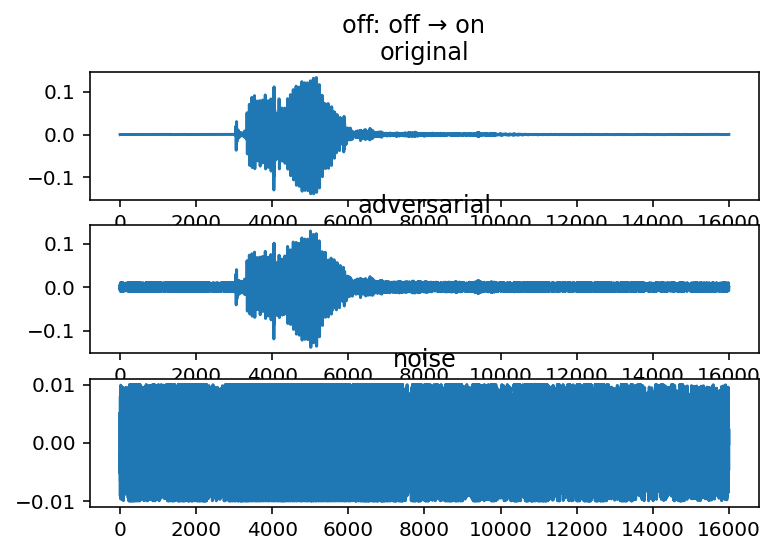

In [24]:
f(model, attack)

torch.Size([16000, 1])
audio/17.mp3


audio/18.mp3


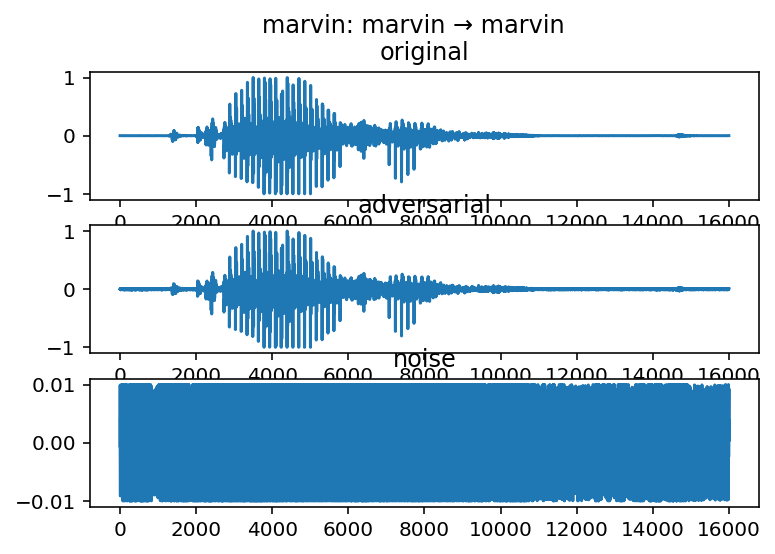

In [25]:
f(model, attack)

torch.Size([16000, 1])
audio/19.mp3


audio/20.mp3


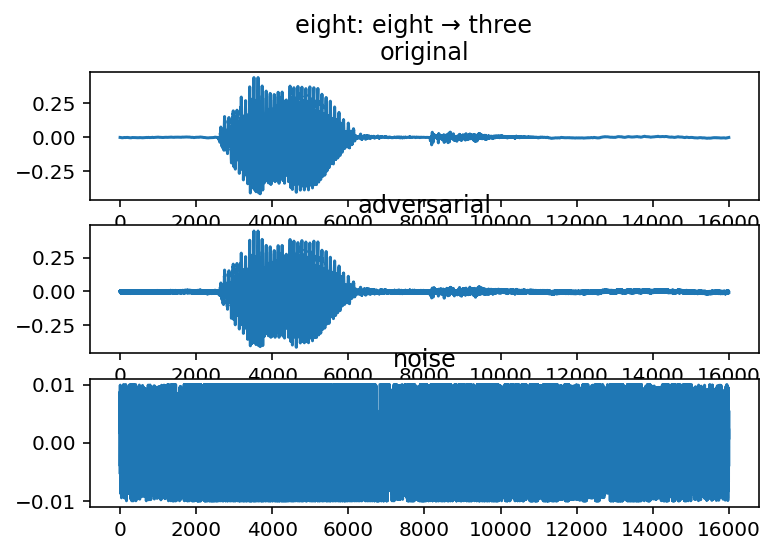

In [26]:
f(model, attack)

In [27]:
logs['free'][1]['train'][0].time

14.370339155197144

In [111]:
linestyles = {
    'pgd': 'dotted',
    'pgds': 'dashdot',
    'nat': 'solid',
    'free': 'dashed',
    'free-s': 'dashed'}
markers = {
    'pgd': '.',
    'pgds': 9,
    'nat': '1',
    'free': '+',
    'free-s': 'x'
}

In [112]:
import itertools

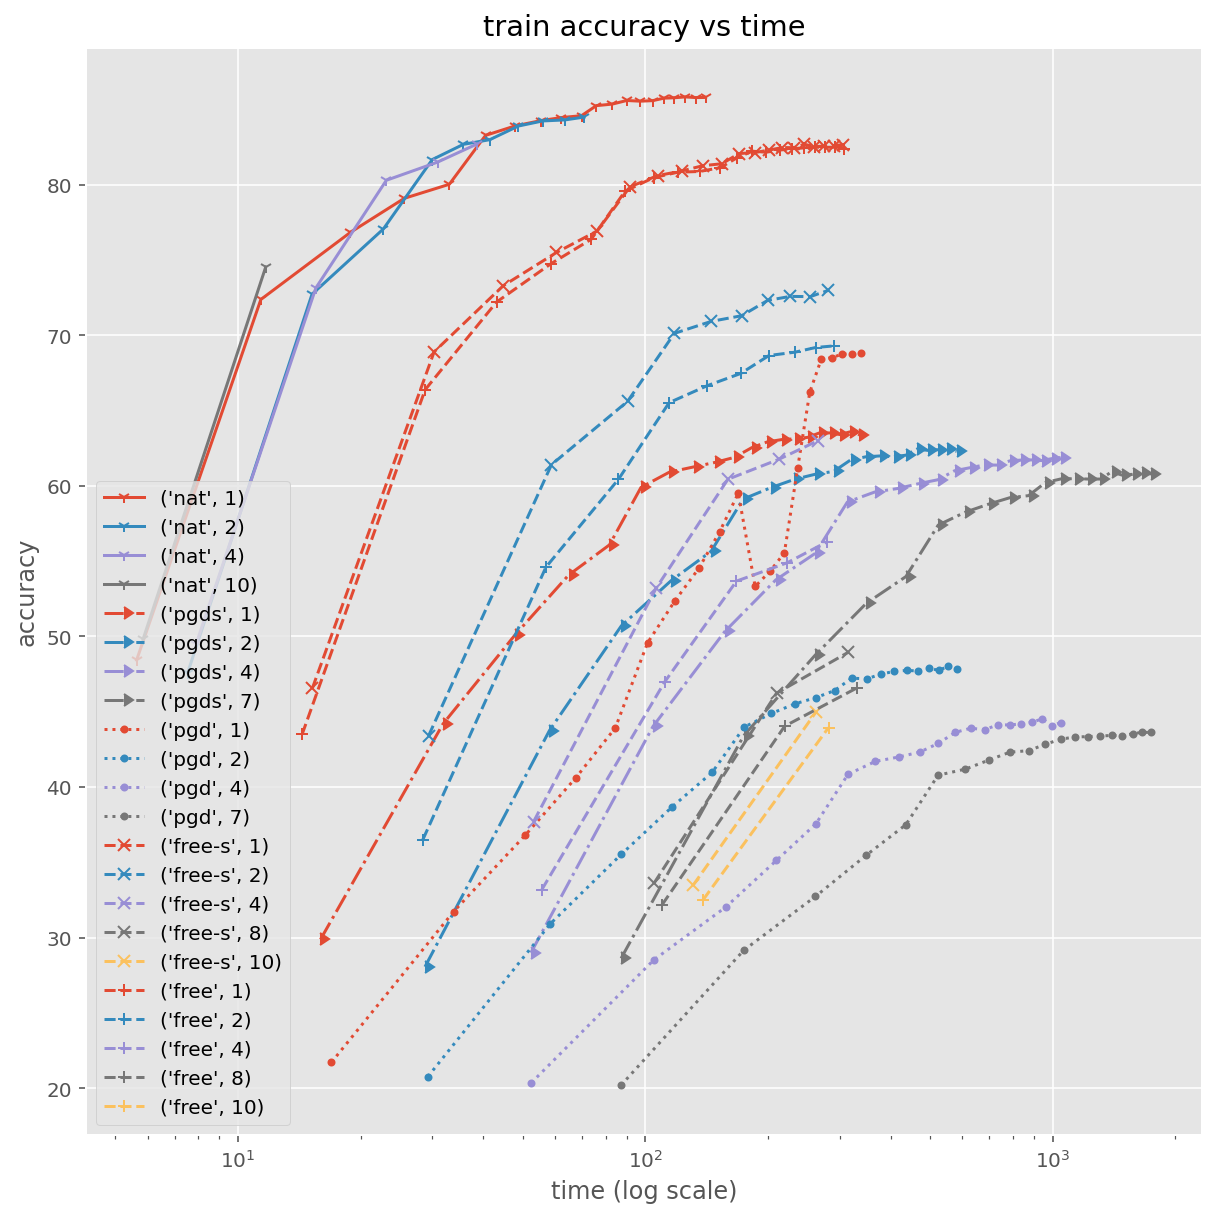

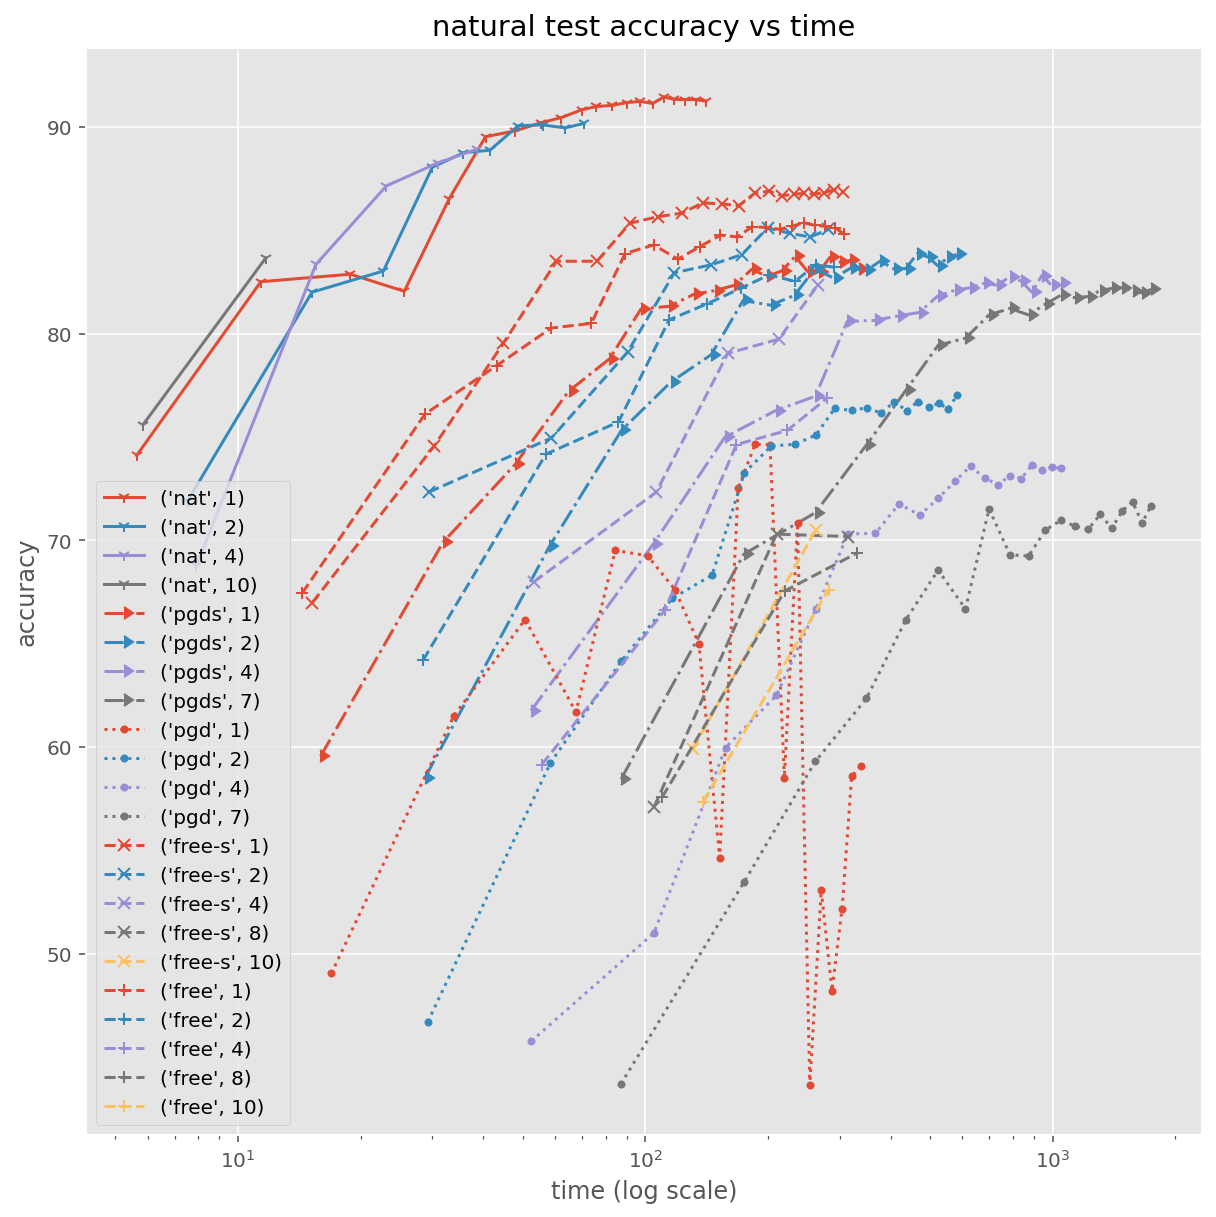

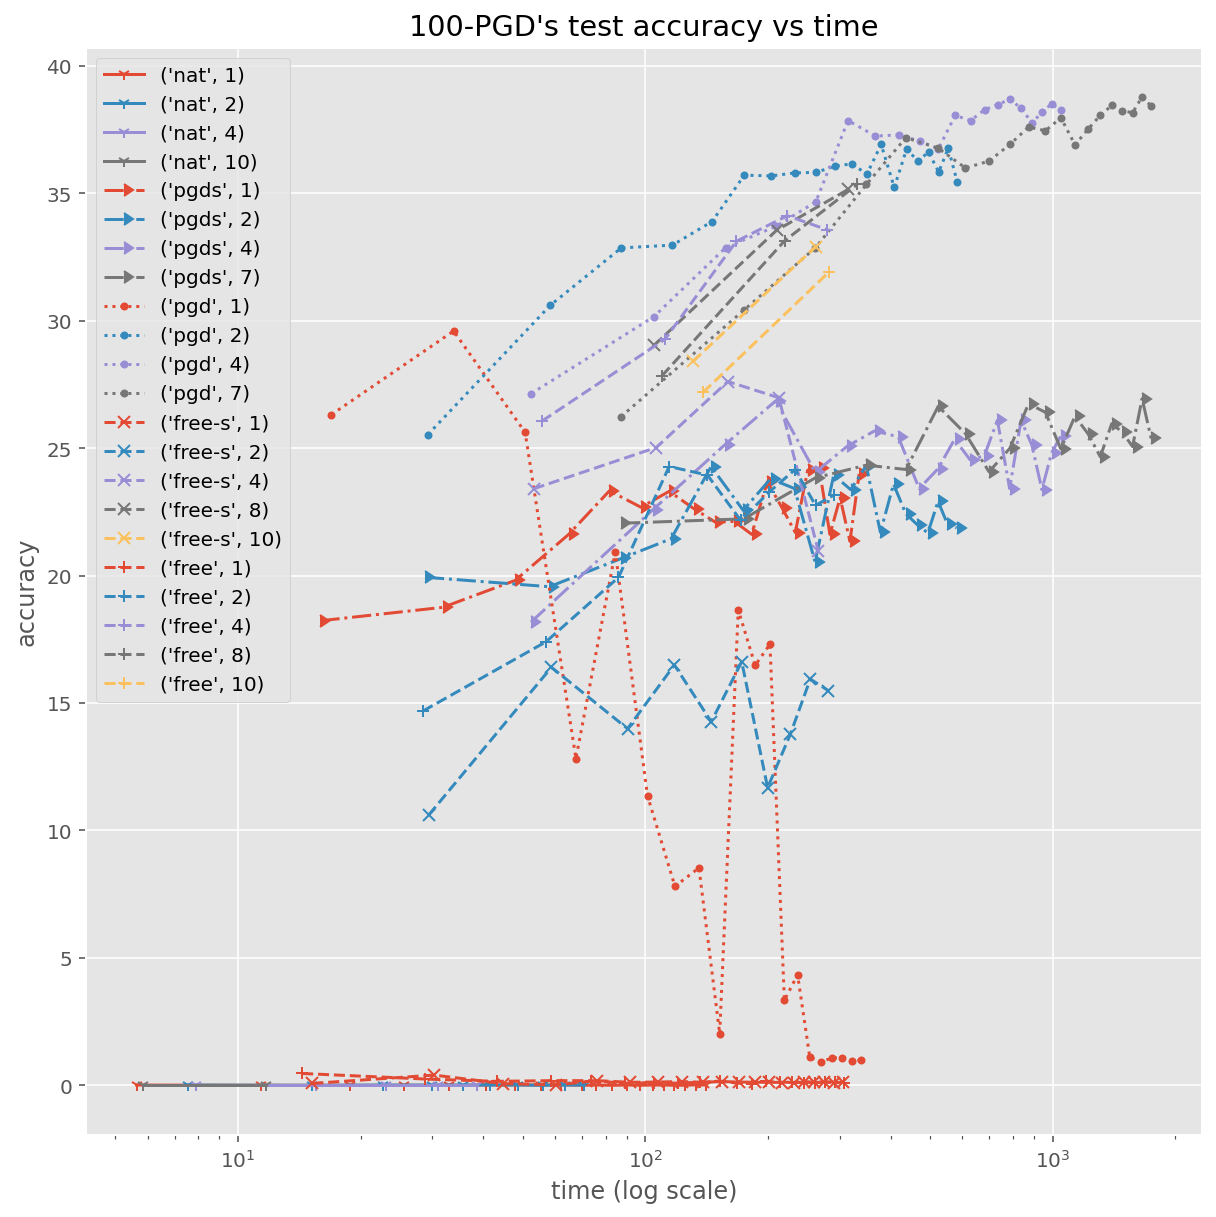

In [114]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 10)
def times(x):
    r = []
    acc = 0
    for i in x:
        acc += i.time
        r.append(acc)
    
    return r
accs = lambda x: [i.acc for i in x]
def ff(t):
    for m in logs.keys():
        for (c, n) in zip(
            itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color']),
            (l := logs[m]).keys()):
            ll = l[n][t]
            if len(logs[m][n]['train']) != len(ll):
                print(m, n, t)
            plt.plot(times(logs[m][n]['train']), 100 * np.array(accs(ll)), label=(m, n), linestyle=linestyles[m], marker=markers[m], c=c)
            
    plt.legend()
    plt.xlabel('time (log scale)')
    plt.xscale('log')
    plt.ylabel('accuracy')
ff('train')
plt.title('train accuracy vs time')
plt.savefig('train.pdf')
plt.savefig('train.svg')
plt.show()

ff('test')
plt.title('natural test accuracy vs time')
plt.savefig('test.pdf')
plt.savefig('test.svg')
plt.show()

ff(f'adv_test/{name}')
plt.title(f'{name}\'s test accuracy vs time')
plt.savefig('adv.svg')
plt.savefig('adv.pdf')
plt.show()

In [192]:
def g(x, t):
    acc = 0
    i = 0
    for i in range(len(x['train'])):
        acc += x['train'][i].time
        if acc > t:
            if acc - t < t + x['train'][i].time - acc:
                pass
            else:
                i -= 1
            break
            
    return min(max(0, i), len(x['train']) - 1)

def gg(t):
    r = []
    for m in logs.keys():
        if m == 'nat':
            continue
        for n in logs[m].keys():
            l = logs[m][n]
            ind = g(l, t)
            ind = np.argmax([i.acc for i in l[f'adv_val/{name}'][:ind + 1]])
            r.append(l[f'adv_test/{name}'][ind].acc)
    return r


In [193]:
cols = {}

ndf = ['time']
for m in logs.keys():
    if m == 'nat':
        continue
    ndf.append(m)
    ndf.extend([''] * (len(logs[m]) - 1))
ndf
cols['best of'] = ndf

mdf = ['']
for m in logs.keys():
    if m == 'nat':
        continue
    for n in logs[m].keys():
        mdf.append(n)
mdf

cols['config'] = mdf


for m in logs.keys():
    if m == 'nat':
        continue
    for n in (l := logs[m]).keys():
        ll = l[n]
        lll = ll[f'adv_val/{name}']
        val_losses = [i.acc for i in lll]
        c = np.argmax(val_losses) + 1
        t = times(ll['train'][:c])[-1]
        cols[f'{m}-{n}'] = [
            t,
            *gg(t)]
        
        
        

In [194]:
df = pd.DataFrame(cols)
df
cols = df.columns.to_list()
cols_ = cols[2:]
df = df[[*cols[:2], *sorted(cols_, key=lambda x: df[x][0])]]

def ffd(x):
    if x.dtype == object:
        return x
    
    
    s = x == np.max(x[1:])
    y = x.map(lambda x:f'{x*100:0.2f}' if x <= 1 else f'{x:0.1f}')
    y[s] = y[s].map(lambda x: f'\\bf{{{x}}}')
    y
    return y
df = df.apply(ffd)
df

,best of,config,free-1,free-s-1,pgd-1,free-s-2,free-2,free-s-4,pgds-4,free-4,free-s-10,pgds-1,free-10,free-s-8,free-8,pgds-2,pgd-2,pgd-4,pgds-7,pgd-7
0,time,,14.4,30.3,33.8,58.8,114.5,159.5,209.1,223.2,262.0,267.2,281.8,315.2,331.5,348.7,379.4,786.0,872.9,1658.3
1,pgds,1,18.23,18.23,18.23,21.62,23.31,23.31,23.68,23.68,24.22,24.22,24.22,24.22,24.22,24.22,24.22,24.22,24.22,24.22
2,,2,19.94,19.94,19.94,19.94,21.44,24.28,24.28,24.28,24.28,24.28,24.28,24.28,24.28,24.32,24.32,24.32,24.32,24.32
3,,4,18.17,18.17,18.17,18.17,22.59,25.13,26.86,26.86,26.86,26.86,26.86,26.86,26.86,26.86,26.86,26.86,26.86,26.86
4,,7,22.05,22.05,22.05,22.05,22.05,22.23,22.23,23.83,23.83,23.83,23.83,24.33,24.33,24.33,24.33,26.64,26.74,26.74
5,pgd,1,26.32,\bf{29.60},\bf{29.60},29.60,29.60,29.60,29.60,29.60,29.60,29.60,29.60,29.60,29.60,29.60,29.60,29.60,29.60,29.60
6,,2,25.53,25.53,25.53,\bf{30.61},\bf{32.97},\bf{33.89},\bf{35.68},\bf{35.80},\bf{35.80},\bf{35.80},\bf{35.80},36.16,36.16,36.16,36.92,36.92,36.92,36.92
7,,4,27.14,27.14,27.14,27.14,30.16,32.87,33.71,33.71,34.67,34.67,34.67,\bf{37.86},\bf{37.86},\bf{37.86},\bf{37.86},\bf{38.69},\bf{38.69},38.69
8,,7,26.23,26.23,26.23,26.23,26.23,30.41,30.41,32.87,32.87,32.87,32.87,35.35,35.35,35.35,35.35,36.92,36.92,\bf{38.78}
9,free-s,1,0.07,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40


In [196]:
df.to_latex('audio.tex', index=False, escape=False)
df.to_html('audio.html', index=False)